## Un'esplorazione del *sentence embedding*

Luca Mari, aggiornamento, maggio 2024

[i file di questa attività: [embed2.ipynb](embed2.ipynb), [embedutils.py](embedutils.py)]

**Obiettivi**: comprendere la logica del *sentence embedding*, applicato anche a interi documenti, il processo con cui una rete neurale artificiale converte documenti in vettori numerici su cui è possibile operare, per esempio per fare ricerche per similarità semantica.  
**Precompetenze**: basi di Python.

Occorre creare un ambiente di lavoro Python, supponiamo con VSCode:
* installare un interprete Python
* scaricare da https://code.visualstudio.com/download e installare VSCode
* eseguire VSCode e attivare le estensioni per Python e Jupyter
* ancora in VSCode:
    * creare una cartella di lavoro e renderla la cartella corrente:  
    * copiare nella cartella questo notebook e il file `embedutils.py` e aprire il notebook
    * creare un ambiente virtuale locale Python (Select Kernel | Python Environments | Create Python Environment | Venv, e scegliere un interprete Python):  
    * installare i moduli Python richiesti, eseguendo dal terminale:  
        `pip install torch transformers multimethod python-docx matplotlib`

Per prima cosa, importiamo il modulo che contiene le funzioni per consentire un accesso "di alto livello" al modello pre-addestrato che opererà sia come tokenizzatore sia come sistema di embedding, usando in questo caso una versione pre-addestrata e fine tuned proprio per sentence embedding, su testi in italiano, di `BERT`, che è un transformer "open" (https://it.wikipedia.org/wiki/BERT) ed eseguibile anche localmente (alla prima esecuzione sarà dunque necessario attendere che il modello sia scaricato dal sito di Hugging Face: è un file di circa 400 MB che viene copiato nella cartella HFdata della propria cartella personale) (non discutiamo qui di come questo modello sia stato addestrato a fare embedding).

In [2]:
from embedutils import Model, read_files

model = Model('nickprock/sentence-bert-base-italian-uncased')

Some weights of BertLMHeadModel were not initialized from the model checkpoint at nickprock/sentence-bert-base-italian-uncased and are newly initialized: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Leggiamo alcuni documenti (quali non è evidentemente così importante...), ognuno dei quali sarà embedded, per consentirci di operare poi sui vettori di embedding così ottenuti.

In [3]:
doc_dir = '/home/lucamari/Documents/Publ/Tutto_Misure/docx'   # cartella contenente i documenti 

metadata = [                                                  # elenco dei file e dei titoli dei documenti
    ("t_m1.docx", "La nuova Guida all'Incertezza di Misura"),
    ("t_m2.docx", "Il nuovo SI (prima parte)"),
    ("t_m3.docx", "Il nuovo SI (seconda parte)"),
    ("t_m4.docx", "La taratura degli strumenti di misura: un tentativo di chiarimento di un problema fondamentale"),
    ("t_m5.docx", "Ancora sul nuovo SI"),
    ("t_m6.docx", "Definizione del misurando e incertezza di definizione: un'introduzione"),
    ("t_m7.docx", "Accuratezza di misura: qualche nota"),
    ("t_m8.docx", "I risultati di misura: un'esplorazione"),
    ("t_m9.docx", "Cos'è la metrologia, insomma?"),
    ("t_m10.docx", "Unità di misura e valori di grandezze: un enigma? (prima parte)"),
    ("t_m11.docx", "Unità di misura e valori di grandezze: un enigma? (seconda parte)"),
    ("t_m12.docx", "Quale ruolo per la metrologia nel mondo dei big data?"),
    ("t_m13.docx", "C'è ancora una differenza tra misurare e calcolare? (prima parte)"),
    ("t_m14.docx", "C'è ancora una differenza tra misurare e calcolare? (seconda parte)"),
    ("t_m15.docx", "La misurazione, tra conservazione e riforma"),
    ("t_m16.docx", "Cosa accadrà alle unità di base nel nuovo SI?"),
    ("t_m17.docx", "Qualche considerazione sul concetto di 'modello di misura'"),
    ("t_m18.docx", "Verso un'incertezza di classificazione - La cultura metrologica nella valutazione delle proprietà classificatorie"),
    ("t_m19.docx", "'Maestra, cos'è un kilo?'"),
    ("t_m20.docx", "La riscoperta del valor vero? (prima parte)"),
    ("t_m21.docx", "La riscoperta del valor vero? (seconda parte)"),
    ("t_m22.docx", "La metrologia tra complessità, incertezza e rischio"),
    ("t_m23.docx", "Le competenze del metrologo, la figura professionale del metrologo"),
    ("t_m24.docx", "Quali competenze ha il metrologo oggi?"),
    ("t_m25.docx", "Verso una nuova edizione del Vocabolario Internazionale di Metrologia (VIM)?"),
    ("t_m26.docx", "A proposito della (spesso sbagliata...) rappresentazione grafica dell'accuratezza e della precisione"),
    ("t_m27.docx", "La scienza della misurazione è una scienza? di che genere?"),
    ("t_m28.docx", "La cultura metrologica tra dataismo e post-verità"),
    ("t_m29.docx", "Il ruolo sociale della cultura metrologica: qualche ipotesi"),
    ("t_m30.docx", "Le scale di misura: un ponte tra mondo empirico e mondo dell'informazione"),
    ("t_m31.docx", "Verso una norma del Tecnico Metrologo"),
    ("t_m32.docx", "Verso un “Manifesto per la cultura metrologica”?"),
    ("t_m33.docx", "Trasformazione digitale: il prossimo obiettivo fondamentale della metrologia fondamentale?"),
    ("t_m34.docx", "In dialogo con un agente artificiale a proposito di qualche argomento di metrologia"),
    ("t_m35.docx", "Una breve introduzione ai sistemi di intelligenza artificiale nella prospettiva della metrologia"),
    ("t_m36.docx", "La terminologia della metrologia: qualche riflessione, con particolare riferimento al caso dei laboratori delle strutture sanitarie"),
    ("t_m37.docx", "La terminologia della metrologia nei laboratori delle strutture sanitarie: un'analisi")
]

texts = read_files(metadata, doc_dir)                         # legge i documenti e li mette in una lista di testi

Sull'esempio del primo documento, mostriamo quella che è forse la più semplice logica di embedding per documenti: si fa l'embedding di un intero documento, calcolando l'embedding di ogni suo token e poi calcolando la media su tutti i token per ogni elemento dei vettori. A questo scopo useremo per ora solamente il primo layer di `BERT`, dunque senza attivarlo effettivamente come transformer.  
Questa semplicità si paga in termini di limitata qualità dei risultati, dato che in questo modo si perde l'informazione sull'ordine dei token nel documento, e quanto più un documento è lungo tanto meno l'embedding finale è significativo.

In [4]:
import numpy as np

text = texts[0][1]
tokens = np.array(model.tokenizer.tokenize(text))
print(f"Il documento ha {tokens.shape[0]} token,")

ids = np.array(model.tokenizer.convert_tokens_to_ids(tokens))
print(f"e corrisponde quindi a una successione di {ids.shape[0]} identificatori numerici.")

print(f"\nDato che ogni identificatore corrisponde a un vettore di {model.embedding_dim} numeri,")

embeddings = model.vocab_embeddings[ids]
print(f"facendo l'embedding della successione si ottiene una matrice di {embeddings.shape} numeri,")

embedding = np.mean(embeddings, axis=0)
print(f"e infine, facendo la media per feature su tutti i token, un vettore di {embedding.shape[0]} numeri.")

Il documento ha 2348 token,
e corrisponde quindi a una successione di 2348 identificatori numerici.

Dato che ogni identificatore corrisponde a un vettore di 768 numeri,
facendo l'embedding della successione si ottiene una matrice di (2348, 768) numeri,
e infine, facendo la media per feature su tutti i token, un vettore di 768 numeri.


In accordo a questa semplice logica, calcoliamo ora l'embedding di tutti i documenti indicati sopra, notando in particolare quanto sia rapido il processo di embedding, che in questo caso è appunto particolarmente semplice anche perché non coinvolge effettivamente il transformer, ma solo il suo primo layer.

In [6]:
embeddings = [model.rough_embed(text) for (_, text) in texts]

Sempre per fare qualche prova, calcoliamo la similarità di ogni coppia di documenti e visualizziamo il risultato in una *heatmap* (che, ovviamente, mostra in particolare, che la massima similarità si ottiene per ogni documento con se stesso).

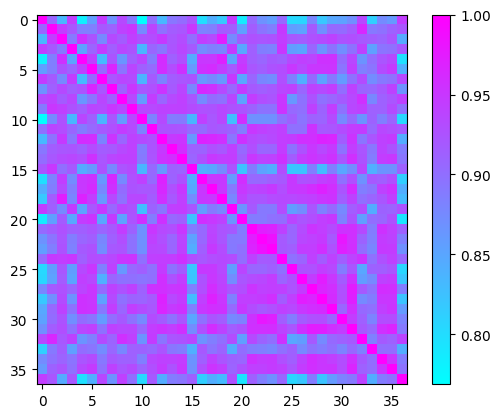

In [7]:
from embedutils import cosine_similarity
import matplotlib.pyplot as plt

similarities = [[cosine_similarity(e1, e2) for e1 in embeddings] for e2 in embeddings]
plt.imshow(similarities, cmap='cool')
plt.colorbar()
plt.show()

Dato un documento, per esempio il primo, possiamo elencare gli *n* documenti che gli sono più simili.

In [8]:
from embedutils import cosine_similarities

top_n = 5
similarities = np.array(cosine_similarities(embeddings[0], embeddings))
indexes = sorted(np.argpartition(similarities, -top_n)[-top_n:], key=lambda i: similarities[i], reverse=True) 
print(f"Gli n={top_n} documenti più simili a '{metadata[0][1]}' sono:")
for i in indexes:
    print(f"-- '{metadata[i][1]}' ({metadata[i][0]}), con similarità {similarities[i]:.3f}")

Gli n=5 documenti più simili a 'La nuova Guida all'Incertezza di Misura' sono:
-- 'La nuova Guida all'Incertezza di Misura' (t_m1.docx), con similarità 1.000
-- 'La riscoperta del valor vero? (prima parte)' (t_m20.docx), con similarità 0.946
-- 'Accuratezza di misura: qualche nota' (t_m7.docx), con similarità 0.946
-- 'La terminologia della metrologia nei laboratori delle strutture sanitarie: un'analisi' (t_m37.docx), con similarità 0.944
-- 'La taratura degli strumenti di misura: un tentativo di chiarimento di un problema fondamentale' (t_m4.docx), con similarità 0.943


Analogamente, data una query possiamo farne l'embedding e quindi elencare gli *n* documenti che gli sono più simili per contenuto, e che quindi potebbero essere i più rilevanti per rispondere alla query stessa.

In [9]:
query = "Cosa sono le unità di misura?"
query_embedding = model.rough_embed(query)

similarities = np.array(cosine_similarities(query_embedding, embeddings))

top_n = 5
indexes = sorted(np.argpartition(similarities, -top_n)[-top_n:], key=lambda i: similarities[i], reverse=True) 
print(f"Gli n={top_n} documenti più simili alla query '{query}' sono:")
for i in indexes:
    print(f"-- '{metadata[i][1]}' ({metadata[i][0]}), con similarità {similarities[i]:.3f}")

Gli n=5 documenti più simili alla query 'Cosa sono le unità di misura?' sono:
-- ''Maestra, cos'è un kilo?'' (t_m19.docx), con similarità 0.590
-- 'Ancora sul nuovo SI' (t_m5.docx), con similarità 0.580
-- 'Qualche considerazione sul concetto di 'modello di misura'' (t_m17.docx), con similarità 0.577
-- 'A proposito della (spesso sbagliata...) rappresentazione grafica dell'accuratezza e della precisione' (t_m26.docx), con similarità 0.570
-- 'Definizione del misurando e incertezza di definizione: un'introduzione' (t_m6.docx), con similarità 0.565


Ricordando che `BERT` è un transformer *encoder only*, possiamo usarlo in quanto tale per generare dei nuovi embedding degli stessi documenti, questa volta in modo più sofisticato perché si tiene conto della posizione dei token nel documento e sono attivi i layer di attenzione del transformer. E infatti il processo di embedding dei documenti è molto più lento del precedente.

In [10]:
embeddings2 = [model.better_embed(text) for (_, text) in texts]

Con questi nuovi vettori di embedding, ripetiamo ora quanto fatto sopra per mettere alla prova la qualità dei risultati ottenuti.

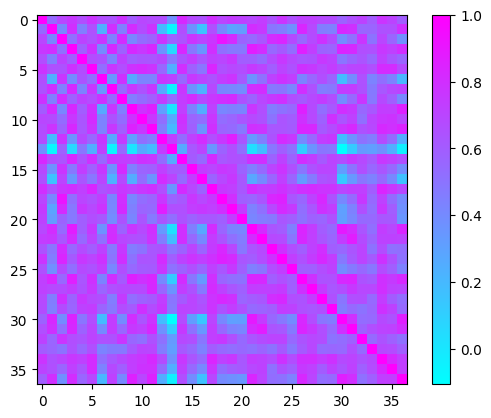

In [11]:
similarities = [[cosine_similarity(e1, e2) for e1 in embeddings2] for e2 in embeddings2]
plt.imshow(similarities, cmap='cool')
plt.colorbar()
plt.show()

In [12]:
top_n = 5
similarities = np.array(cosine_similarities(embeddings2[0], embeddings2))
indexes = sorted(np.argpartition(similarities, -top_n)[-top_n:], key=lambda i: similarities[i], reverse=True) 
print(f"Gli n={top_n} documenti più simili a '{metadata[0][1]}' sono:")
for i in indexes:
    print(f"-- '{metadata[i][1]}' ({metadata[i][0]}), con similarità {similarities[i]:.3f}")

Gli n=5 documenti più simili a 'La nuova Guida all'Incertezza di Misura' sono:
-- 'La nuova Guida all'Incertezza di Misura' (t_m1.docx), con similarità 1.000
-- 'La misurazione, tra conservazione e riforma' (t_m15.docx), con similarità 0.819
-- 'Verso un'incertezza di classificazione - La cultura metrologica nella valutazione delle proprietà classificatorie' (t_m18.docx), con similarità 0.793
-- 'Cos'è la metrologia, insomma?' (t_m9.docx), con similarità 0.777
-- 'Una breve introduzione ai sistemi di intelligenza artificiale nella prospettiva della metrologia' (t_m35.docx), con similarità 0.774


In [28]:
query = "Cosa sono le unità di misura?"
query_embedding = model.better_embed(query)

similarities = np.array(cosine_similarities(query_embedding, embeddings2))

top_n = 5
indexes = sorted(np.argpartition(similarities, -top_n)[-top_n:], key=lambda i: similarities[i], reverse=True) 
print(f"Gli n={top_n} documenti più simili alla query '{query}' sono:")
for i in indexes:
    print(f"-- '{metadata[i][1]}' ({metadata[i][0]}), con similarità {similarities[i]:.3f}")

Gli n=5 documenti più simili alla query 'Cosa sono le unità di misura?' sono:
-- 'Il nuovo SI (prima parte)' (t_m2.docx), con similarità 0.611
-- 'Verso una norma del Tecnico Metrologo' (t_m31.docx), con similarità 0.589
-- 'I risultati di misura: un'esplorazione' (t_m8.docx), con similarità 0.565
-- 'Unità di misura e valori di grandezze: un enigma? (prima parte)' (t_m10.docx), con similarità 0.535
-- 'La taratura degli strumenti di misura: un tentativo di chiarimento di un problema fondamentale' (t_m4.docx), con similarità 0.526


E plausibilmente otterremmo risultati ancora migliori se usassimo il transformer per fare l'embedding non di interi documenti, ma di loro parti (*chunks*). Proviamo dividendo in paragrafi: notiamo che ora il processo di embedding, ripetuto dunque su un numero maggiore di testi, è ancora più lento del precedente.

In [32]:
from embedutils import read_files2

paragraphs = read_files2(metadata, doc_dir)

p_len = [len(text) for (_, _, text) in paragraphs]
print(f"Numero di paragrafi: {len(p_len)}; lunghezza media: {np.mean(p_len):.2f}; massima: {np.max(p_len)}; minima: {np.min(p_len)}")

Numero di paragrafi: 839; lunghezza media: 553.75; massima: 2852; minima: 101


In [15]:
embeddings3 = [model.better_embed(text) for (_, _, text) in paragraphs]

In [42]:
from pprint import pprint

query = "Cosa sono le unità di misura?"
query_embedding = model.better_embed(query)

similarities = np.array(cosine_similarities(query_embedding, embeddings3))

top_n = 5
indexes = sorted(np.argpartition(similarities, -top_n)[-top_n:], key=lambda i: similarities[i], reverse=True) 
print(f"Gli n={top_n} paragrafi più simili alla query '{query}' sono:\n")
for i in indexes:
    print(f"-- {paragraphs[i][0]}, paragrafo {paragraphs[i][1]}, con similarità {similarities[i]:.3f}")
    pprint({paragraphs[i][2]})
    print()

Gli n=5 paragrafi più simili alla query 'Cosa sono le unità di misura?' sono:

-- t_m23.docx, paragrafo 18, con similarità 0.823
{'gli elementi di base di analisi matematica, statistica e informatica '
 'necessari per la progettazione del processo di misura e l’elaborazione dei '
 'dati di misura, e'}

-- t_m10.docx, paragrafo 10, con similarità 0.809
{'unità di misura: grandezza scalare reale, definita e adottata per '
 'convenzione, rispetto alla quale è possibile confrontare ogni altra '
 'grandezza della stessa specie al fine di esprimere il rapporto delle due '
 'grandezze come un numero'}

-- t_m36.docx, paragrafo 3, con similarità 0.809
{'unità di misura: grandezza scalare reale, definita e adottata per '
 'convenzione, rispetto alla quale è possibile confrontare ogni altra '
 'grandezza della stessa specie al fine di esprimere il rapporto delle due '
 'grandezze come un numero'}

-- t_m17.docx, paragrafo 11, con similarità 0.784
{'Ciò rende ben conto del ruolo fondamentale dell

Proviamo un'altra volta, ora dividendo il testo di ogni documento in frasi. 

In [30]:
from embedutils import read_files3

sentences = read_files3(metadata, doc_dir)

s_len = [len(text) for (_, _, text) in sentences]
print(f"Numero di frasi: {len(s_len)}; lunghezza media: {np.mean(s_len):.2f}; massima: {np.max(s_len)}; minima: {np.min(s_len)}")

Numero di frasi: 2381; lunghezza media: 193.21; massima: 923; minima: 11


In [27]:
embeddings4 = [model.better_embed(text) for (_, _, text) in sentences]

In [41]:
from pprint import pprint

query = "Cosa sono le unità di misura?"
query_embedding = model.better_embed(query)

similarities = np.array(cosine_similarities(query_embedding, embeddings4))

top_n = 5
indexes = sorted(np.argpartition(similarities, -top_n)[-top_n:], key=lambda i: similarities[i], reverse=True) 
print(f"Le n={top_n} frasi più simili alla query '{query}' sono:\n")
for i in indexes:
    print(f"-- {sentences[i][0]}, frase {sentences[i][1]}, con similarità {similarities[i]:.3f}")
    pprint({sentences[i][2]})
    print()

Le n=5 frasi più simili alla query 'Cosa sono le unità di misura?' sono:

-- t_m30.docx, frase 39, con similarità 0.867
{' Cos’è una scala di misura, dunque?'}

-- t_m10.docx, frase 58, con similarità 0.836
{'Con ciò l’investigatore ha fornito una giustificazione all’obiezione '
 'preliminare che gli era stata rivolta, e può dunque cominciare la sua '
 'indagine intorno al problema: cos’è un’unità di misura?'}

-- t_m5.docx, frase 54, con similarità 0.825
{'Un sistema di unità è dunque definito secondo questa logica:'}

-- t_m23.docx, frase 48, con similarità 0.823
{'gli elementi di base di analisi matematica, statistica e informatica '
 'necessari per la progettazione del processo di misura e l’elaborazione dei '
 'dati di misura, e'}

-- t_m19.docx, frase 13, con similarità 0.815
{' Ma anche costoro si riferiscono alle unità di misura quando operano con '
 'valori di grandezze'}



Anche se pare che i risultati siano corretti, è evidente che le singole frasi sono generalmente troppo brevi per ricevarne un contesto, e quindi una risposta alla domanda. Una volta trovate le singole frasi più rilevanti, possiamo allora per esempio estendere la risposta concatenando a ogni frase trovata le *n* frasi precedenti e le *n* successive.

In [43]:
ext_n = 2

print(f"Le n={top_n} frasi estese più simili alla query '{query}' sono:\n")
for i in indexes:
    print(f"-- {sentences[i][0]}, frasi {sentences[i][1]-ext_n}-{sentences[i][1]+ext_n}, con similarità {similarities[i]:.3f}")
    pprint(' '.join([sentences[i+j][2] for j in range(-ext_n, ext_n+1)]))

    #pprint(f"{sentences[i][2]}")
    print()

Le n=5 frasi estese più simili alla query 'Cosa sono le unità di misura?' sono:

-- t_m8.docx, frasi 54-58, con similarità 0.823
(' Il metodo Monte Carlo, basato sulla non problematica disponibilità di '
 'risorse di calcolo, mostra come calcolare funzioni su distribuzioni di '
 'probabilità, e quindi fornisce uno strumento per applicare le leggi della '
 'fisica a distribuzioni di probabilità Il quadro che emerge da questa '
 'molteplicità di opzioni è di notevole flessibilità, concettuale e '
 'applicativa  Con generalizzazioni progressive, abbiamo visto che un '
 'risultato di misura può essere: – un singolo valore di grandezza, il cui '
 'numero di cifre significative porta l’informazione sull’incertezza di '
 'misura; – una coppia valore misurato, incertezza tipo;')

-- t_m4.docx, frasi 19-23, con similarità 0.809
(' confusione?): «Spesso, solamente la prima fase citata nella presente '
 'definizione è interpretata come taratura Dunque? Una sola o due fasi? Un '
 'tentativo di chi